In [1]:
%matplotlib inline

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# some default imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# we will use arviz for some of the plotting
import arviz as az

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

from jax import numpy as jnp, random
from numpyro import sample, handlers
import numpyro.distributions as dist
from numpyro.distributions import (
    Categorical,
    Dirichlet,
    ImproperUniform,
    Normal,
    OrderedLogistic,
    TransformedDistribution,
    constraints,
    transforms,
)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

# Ordinal regression

Let's demonstrate a simple model of ordinal inference over a set of scores using _numpyro_. I'm going to follow closely the examples in the numpyro docs [here](https://num.pyro.ai/en/stable/tutorials/ordinal_regression.html), as well as Betancourt notes [here](https://betanalpha.github.io/assets/case_studies/ordinal_regression.html).

## Background

Let $Y$ be an ordinal variable (i.e., a variable that can only take one of a number of discrete, ordered values: $Y_0 < Y_1 < ... < Y_{K-1}$), for which we have a number of measurements (e.g., rankings from a survey of several respondents/judges). To get a posterior on the true value of $Y$, we will introduce an auxiliary latent variable $X$, which is defined over the reals ($X \in \mathbb{R}$). Instead of working directly in the discrete space of $Y$, we can model a latent distribution in the $X$ space, which is continuous and unbounded.

To do this, we need a mapping from $X$ to $Y$ or, rather, a discretization procedure that takes us from $X$ to $Y$. This can be achieved by partitioning the $X$ domain into $K$ segments defined by a series of $K+1$ _cut points_ $c_k$, with $c_0 = -\infty < c_1 < \dots < c_{K-1} < c_K = \infty$, so that probability mass within each $(c_k, c_{k+1})$ segment is assigned to $Y_k$.

With this setup, all we need is a prescription for the probability density on $X$, $p(X)$. Within reason, the specific choice doesn't matter because we can always counteract changes in the shape of this distribution by tweaking the cut points, so we can pick $p(X)$ for computational convenience. A common choice is a logistic PDF, given by
$$
p(x) = \frac{e^{-x}}{\left(1 + e^{-x}\right)^2} ~ ;
$$
the CDF of this PDF, i.e. $\Phi(x) = \int_\infty^x p(x') {\rm }dx'$, is the logistic function, namely
$$
\Phi(x) = \frac{e^{x}}{1+ e^{x}} ~ .
$$
This is an _ordinal logistic model_.

## Inferring probabilities

The simplest application of the logistic model is to measure the underlying probabilities $p_k$ associated with each bin (category) $Y_k$, based on counts for $Y_k$. Typically, for a setup like this, we could simply use a multinomial model; however, that does not take into account the _ordering_ of the categories and, therefore, the expected correlations between nearby bins.

Imagine we have a survey with `n_bins` ranked categories to choose from (e.g., "rank the quality of service from 0 to 5"), and that we have received `n_resp` responses. How do we estimate the true fraction of responses in each category based on a finite sample?

In [24]:
# create some data based on Betancourt's example for sanity checking
scores = np.array([2, 4, 13, 22, 9])

n_bins = len(scores)
n_resp = sum(scores)

In [ ]:
Y = [[i]*v for i,v in enumerate(scores)]
# flatten the list
Y = jnp.array([item for sublist in Y for item in sublist])

### Improper prior with no affinity

We will model the above draws as taken from a categorical process with unknown cut points and measure the location of the cut points. We will start wih an improper uniform prior on the cut points; we will set the affinitiy to zero because it's fully degenerate with the location of the cut points in this case.

In [58]:
def model0a(Y, nclasses=n_bins, eta=0):
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    with numpyro.plate("obs", len(Y)):
        sample("data", OrderedLogistic(eta, c_y), obs=Y)

# split prngkey

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model0a)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y)
mcmc.print_summary()

# get posterior predictive
predictive = numpyro.infer.Predictive(model0a, mcmc.get_samples())
pred = predictive(pred_key, Y)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 746.87it/s, 15 steps of size 2.10e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    c_y[0]     -3.55      0.86     -3.48     -4.84     -2.18    223.63      1.00
    c_y[1]     -2.08      0.46     -2.05     -2.87     -1.40    506.35      1.00
    c_y[2]     -0.51      0.30     -0.50     -1.01     -0.06    803.78      1.00
    c_y[3]      1.58      0.39      1.54      0.96      2.21    722.40      1.00

Number of divergences: 0


We've obtained a range of potential mappings for the cuts in the logistic space:

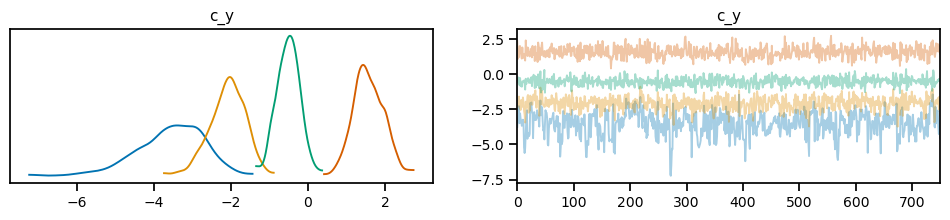

In [59]:
result = az.from_numpyro(mcmc)
az.plot_trace(result);

Since our model is simply mapping the $Y$ observations to the latent space, we recover the original histogram no matter what the value of the latent cuts:

In [60]:
df_pred = pd.DataFrame(pred['data'])
df_pred.apply(lambda x: x.value_counts(), axis=1)

,3,2,4,1,0
0,22,13,9,4,2
1,22,13,9,4,2
2,22,13,9,4,2
3,22,13,9,4,2
4,22,13,9,4,2
...,...,...,...,...,...
745,22,13,9,4,2
746,22,13,9,4,2
747,22,13,9,4,2
748,22,13,9,4,2


### Improper prior with affinity

We now check the effect of including an affinity in our model. The affinity parameter $\gamma$ can shift the overall distribution up and down the axis, so it is degenerate with the overall location of the cuts.

#### Uniform affinity prior

We start by setting no prior on the affinity, which will make this problem fully degenerate.

In [65]:
def model0b(Y, nclasses=n_bins):
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    gamma = sample(
        "gamma",
        ImproperUniform(
            support=constraints.real,
            batch_shape=(),
            event_shape=(1,),
        ),
    )
    with numpyro.plate("obs", len(Y)):
        sample("data", OrderedLogistic(gamma, c_y), obs=Y)

# split prngkey

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model0b)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y)
mcmc.print_summary()

# get posterior predictive
predictive = numpyro.infer.Predictive(model0b, mcmc.get_samples())
pred = predictive(pred_key, Y)

df_pred = pd.DataFrame(pred['data'])

sample: 100%|██████████| 1000/1000 [00:02<00:00, 412.75it/s, 1023 steps of size 1.68e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    c_y[0]    864.19    301.20    851.01    444.57   1402.25      9.04      1.05
    c_y[1]    865.71    301.24    852.08    446.47   1403.84      9.05      1.05
    c_y[2]    867.31    301.21    853.47    447.84   1405.40      9.05      1.05
    c_y[3]    869.37    301.23    855.40    450.13   1407.95      9.05      1.05
  gamma[0]    867.80    301.22    853.78    448.80   1406.16      9.05      1.05

Number of divergences: 0


,3,2,4,1,0
0,22,13,9,4,2
1,22,13,9,4,2
2,22,13,9,4,2
3,22,13,9,4,2
4,22,13,9,4,2
...,...,...,...,...,...
745,22,13,9,4,2
746,22,13,9,4,2
747,22,13,9,4,2
748,22,13,9,4,2


We've obtained a range of potential mappings for the cuts in the logistic space:

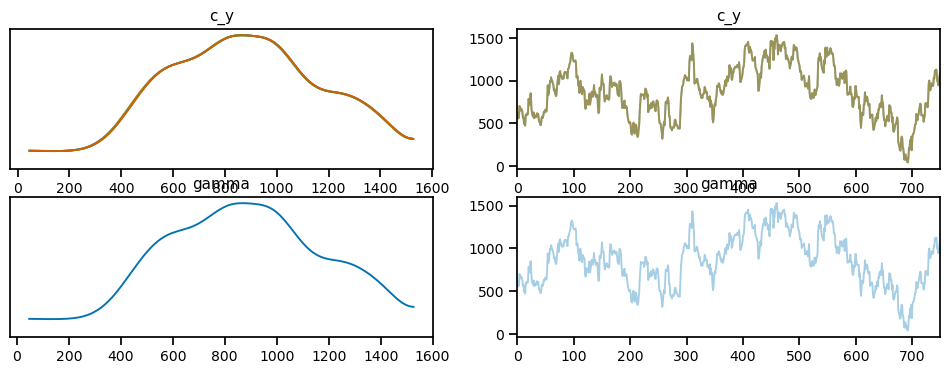

In [62]:
result = az.from_numpyro(mcmc)
az.plot_trace(result);

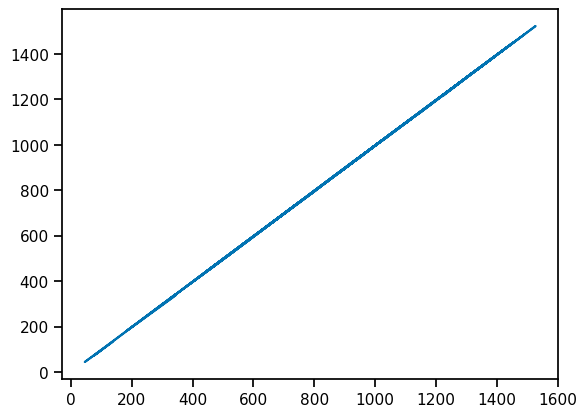

In [63]:
plt.plot(result.posterior["gamma"].values.flatten(), result.posterior["c_y"].values[:,:,0].flatten())

With this setup, the affinity and the cuts are fully degenerate, as we expect.

#### Gausian affinity prior

We can partially anchor the problem by setting a Gaussian prior on the affinity, which will partially break some degeneracies.

In [66]:
def model0b(Y, nclasses=n_bins):
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    gamma = sample(
        "gamma",
        Normal(),
    )
    with numpyro.plate("obs", len(Y)):
        sample("data", OrderedLogistic(gamma, c_y), obs=Y)

# split prngkey

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model0b)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y)
mcmc.print_summary()

# get posterior predictive
predictive = numpyro.infer.Predictive(model0b, mcmc.get_samples())
pred = predictive(pred_key, Y)

df_pred = pd.DataFrame(pred['data'])

sample: 100%|██████████| 1000/1000 [00:01<00:00, 678.36it/s, 31 steps of size 1.45e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    c_y[0]     -3.75      1.37     -3.78     -5.93     -1.47    351.40      1.00
    c_y[1]     -2.18      1.13     -2.26     -4.20     -0.47    506.89      1.00
    c_y[2]     -0.57      1.07     -0.62     -2.60      0.95    493.10      1.00
    c_y[3]      1.51      1.08      1.50     -0.23      3.32    567.73      1.00
     gamma     -0.07      1.03     -0.13     -1.78      1.62    517.26      1.00

Number of divergences: 0


We've obtained a range of potential mappings for the cuts in the logistic space:

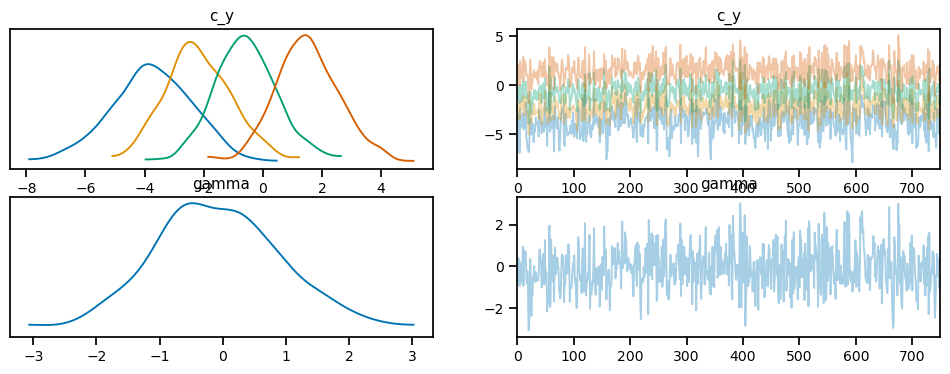

In [67]:
result = az.from_numpyro(mcmc)
az.plot_trace(result);

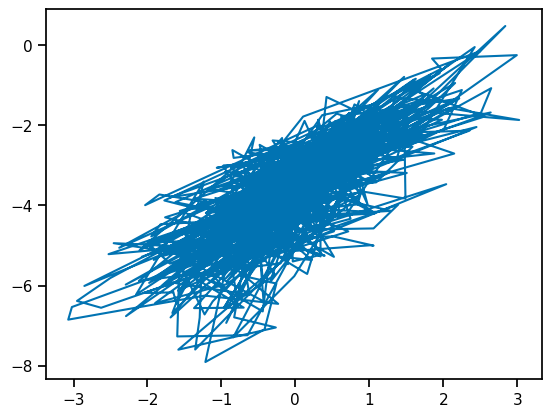

In [68]:
plt.plot(result.posterior["gamma"].values.flatten(), result.posterior["c_y"].values[:,:,0].flatten())

We have broken some of the degeneracy and recovered a result similar to the above with $\gamma = 0$.

### Dirichlet prior

We can repeat the above, but now modeling the histogram as a Dirichlet process.

In [71]:
# We will apply a nudge towards equal probability for each category (corresponds to equal logits of the true data generating process)
concentration = np.ones((n_bins,)) * 10.0

In [73]:
def model4(Y, nclasses, concentration, anchor_point=0.0):

    with handlers.reparam(config={"c_y": TransformReparam()}):
        c_y = sample(
            "c_y",
            TransformedDistribution(
                Dirichlet(concentration),
                transforms.SimplexToOrderedTransform(anchor_point),
            ),
        )
    gamma = sample(
        "gamma",
        ImproperUniform(
            support=constraints.real,
            batch_shape=(),
            event_shape=(1,),
        ),
    )
    with numpyro.plate("obs", X.shape[0]):
        sample("Y", OrderedLogistic(gamma, c_y), obs=Y)


kernel = NUTS(model4)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y, n_bins, concentration)
# with exclude_deterministic=False, we will also show the ordinal probabilities sampled from Dirichlet (vis. `c_y_base`)
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 633.87it/s, 7 steps of size 5.13e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     c_y[0]     -1.65      0.38     -1.64     -2.23     -0.98    544.89      1.00
     c_y[1]     -0.62      0.31     -0.61     -1.19     -0.17    378.12      1.00
     c_y[2]      0.47      0.31      0.47     -0.03      0.93    367.60      1.00
     c_y[3]      2.02      0.37      2.01      1.46      2.63    476.34      1.00
c_y_base[0]      0.17      0.05      0.16      0.08      0.25    512.85      1.00
c_y_base[1]      0.19      0.05      0.18      0.11      0.26    625.13      1.00
c_y_base[2]      0.26      0.05      0.25      0.18      0.34    943.84      1.00
c_y_base[3]      0.27      0.05      0.26      0.18      0.34    538.42      1.00
c_y_base[4]      0.12      0.04      0.12      0.06      0.18    429.80      1.00
   gamma[0]      0.88      0.38      0.89      0.32      1.53    372.31      1.00

Number of divergences: 0


In [75]:
# get posterior predictive
predictive = numpyro.infer.Predictive(model4, mcmc.get_samples())
pred = predictive(pred_key, Y, n_bins, concentration)

df_pred = pd.DataFrame(pred['Y'])

In [76]:
df_pred

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
1,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
2,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
3,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
4,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
746,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
747,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4
748,0,0,1,1,1,1,2,2,2,2,...,3,4,4,4,4,4,4,4,4,4


Create some data based on the numpyro example for sanity checking. We can generate categorical data using the `Categorical` class in numpro; this will produce categorical draws for a number of bins, with probabilities specified by either a `probs` argument or a `logits` argument, which should be vectors with the same length as the number of bins. Recall that the logit is just an equivalent way of specifying the probability $p$, and it's given by
$$
l \equiv {\rm logit}(p) = \ln\left(\frac{p}{1-p}\right) ;
$$ 
this corresponds to the log odds, i.e., the logarithm of the odds $p /( 1-p)$. The transformation from a set of logits to probabilities is obtained through the _softmax function_,
$$
p_i(\{l_0, \dots , l_{K-1}\}) = \frac{e^l_i}{\sum_{k=0}^{K-1} e^{l_k}} ~ ,
$$
which guarantees that the probabilities are normalized correctly.

In [12]:
simkeys = random.split(random.PRNGKey(1), 2)

n_resp = 50
n_bins = 3

# the Categorical class will draw samples from a categorical distribution
# defined over a set of bins, with probabilities given by the logits argument
Y = Categorical(logits=jnp.zeros(n_bins)).sample(simkeys[0], sample_shape=(n_resp,))

# create corresponding noisy observations in the latent space of X by sampling
# from a Normal distribution
X = Normal().sample(simkeys[1], sample_shape=(n_resp,))
X += Y

print("value counts of Y:")
df = pd.DataFrame({"X": X, "Y": Y})
print(df.Y.value_counts())

for i in range(n_bins):
    print(f"mean(X) for Y == {i}: {X[jnp.where(Y==i)].mean():.3f}")

value counts of Y:
Y
0    19
2    17
1    14
Name: count, dtype: int64
mean(X) for Y == 0: 0.462
mean(X) for Y == 1: 1.077
mean(X) for Y == 2: 1.856


In [13]:
Y

Array([1, 1, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 0,
       0, 0, 0, 2, 1, 2, 0, 1, 0, 1, 0, 2, 2, 0, 1, 1, 0, 0, 1, 2, 0, 0,
       0, 0, 2, 2, 2, 1], dtype=int64)

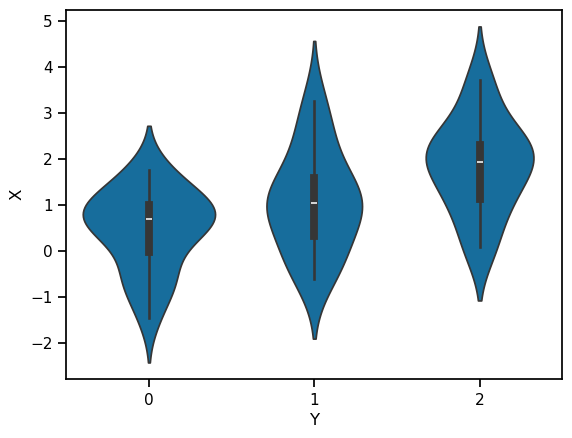

In [5]:
sns.violinplot(x="Y", y="X", data=df);

In [54]:
# df = pd.read_csv('ranking_data_anon.csv', index_col=None)
# df[df['Category'] == 'Clarity']['Candidate-0']

In [57]:
def model1(X, Y, nclasses=3):
    b_X_eta = sample("b_X_eta", Normal(0, 5))
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    with numpyro.plate("obs", X.shape[0]):
        eta = X * b_X_eta
        sample("Y", OrderedLogistic(eta, c_y), obs=Y)


mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model1)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X, Y, n_bins)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 585.00it/s, 7 steps of size 4.27e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.07      0.27      1.06      0.63      1.50    419.55      1.00
    c_y[0]      0.48      0.38      0.47     -0.15      1.06    459.36      1.00
    c_y[1]      2.06      0.47      2.02      1.22      2.73    447.09      1.00

Number of divergences: 0


A common application of logistic regression is to find the relationship between the outcomes of $Y$ and some continuous predictor variable $X$. For example, $Y$ could represent different stages of a disease and $X$ a biomarker whose levels correlate with the diseases; in that case, we would want to determine the stage of the disease in the patient given their biomarkers.